# Example navigation workflow

## lat-lon grid for Jupiter HST data

In [1]:
# package imports
from pylanetary import navigation
from pylanetary.utils import Body
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

### import the data and scrape header

In [2]:
# hst parameters
hdul = fits.open('/Users/emolter/Python/pylanetary/pylanetary/navigation/tests/data/hlsp_wfcj_hst_wfc3-uvis_jupiter-2017-pj07_f631n_v2_0711ut0947-nav.fits')
data = hdul[1].data
obs_time = hdul[0].header['DATE-OBS']+' '+hdul[0].header['TIME-OBS']
rotation = float(hdul[0].header['ORIENTAT'])
pixscale_arcsec = float(hdul[0].header['PIXSCAL'])

### instantiate a Nav object

In [3]:
# instantiate the nav object
jup = Body('Jupiter', epoch=obs_time, location='@hst') 

#North is not up in the image; this hack of the ephemeris data solves this problem
jup.ephem['NPole_ang'] = jup.ephem['NPole_ang'] - rotation

#data[np.isnan(data)] = 0.0
nav = navigation.Nav(data, jup, pixscale_arcsec)

### attempt co-locate

Here we are using a limb-darkened disk model with an exponential darkening law. I just chose a=0.7 ad-hoc here, since I didn't know what a good value was

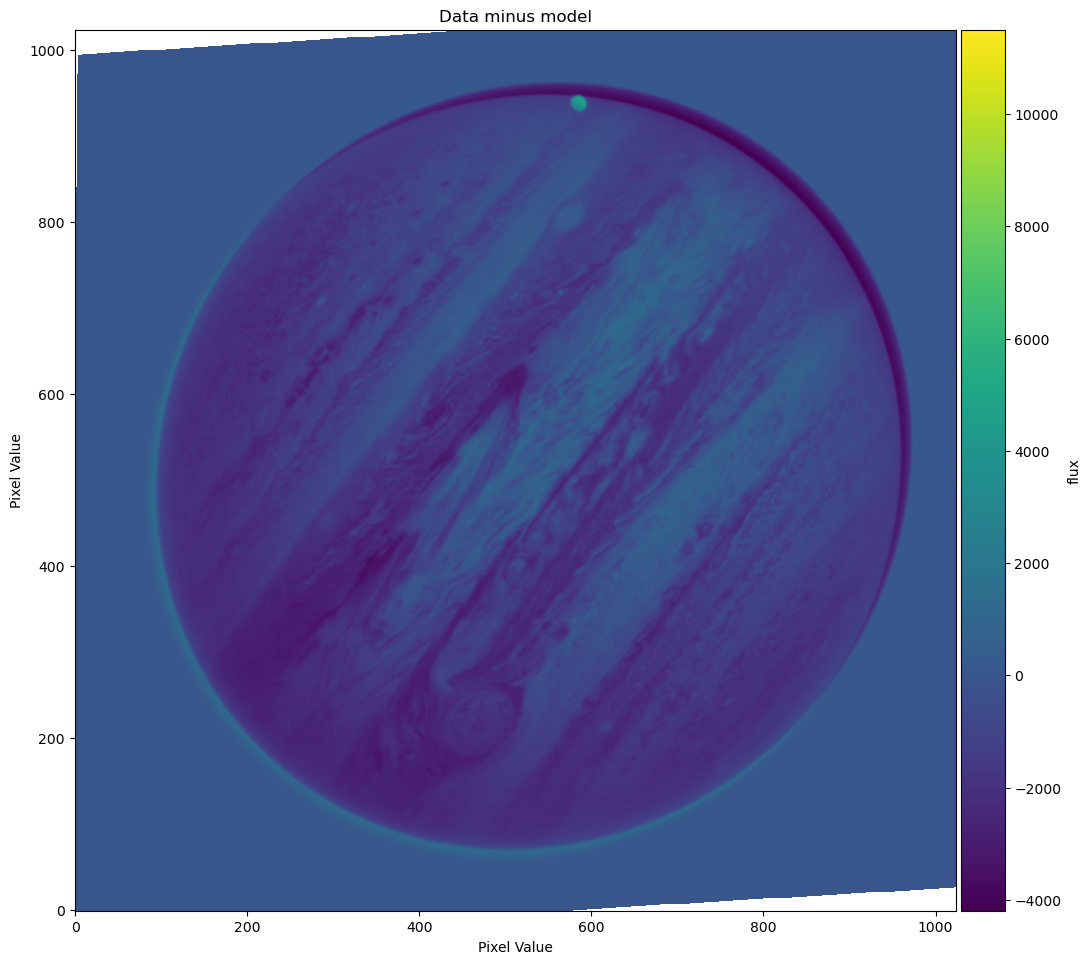

In [4]:
flux = 1.15e4 # surface brightness in whatever units are in the fits file
a = 0.7 # exponential limb-darkening law exponent
fwhm = 3 # approximate FWHM of the point-spread function in pixels
dx, dy, dxerr, dyerr = nav.colocate(mode='disk', 
        tb = flux, 
        a = a, 
        law = 'exp',
        beam = fwhm, 
        diagnostic_plot=True,
        )

### assess fit quality

This fit doesn't look very good. As the diagnostic plot shows, there is a bright (positive) edge to the lower left and a dark (negative) edge to the upper right, indicating that the model center is up and to the right of the true center.
Let's look at the data and limb-darkened model side by side to see how they both look.

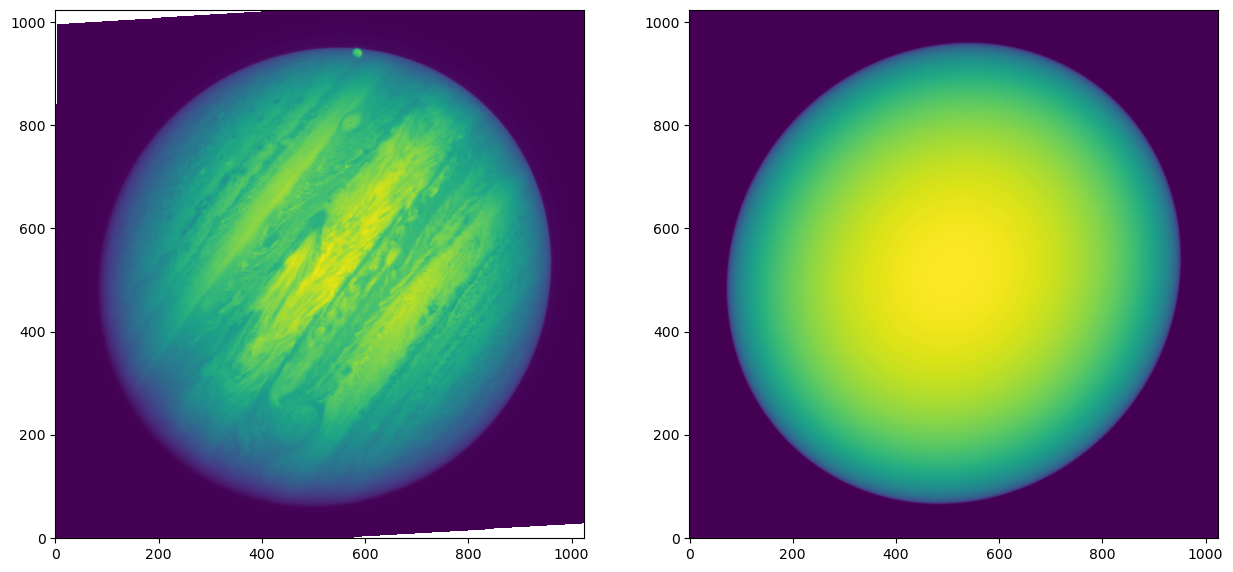

In [5]:
ldmodel = nav.ldmodel(flux, a, beam=fwhm, law='exp')
fig, (ax0, ax1) = plt.subplots(1,2, figsize = (15,10))
ax0.imshow(nav.data, origin='lower')
ax1.imshow(ldmodel, origin = 'lower')
plt.show()

### re-try with better model

We can see that in the real data, the sub-solar point is somewhere toward the upper right of the center of the planet, whereas in our model the brightest point on the disk is at center. Let's try using a Minnaert law instead.

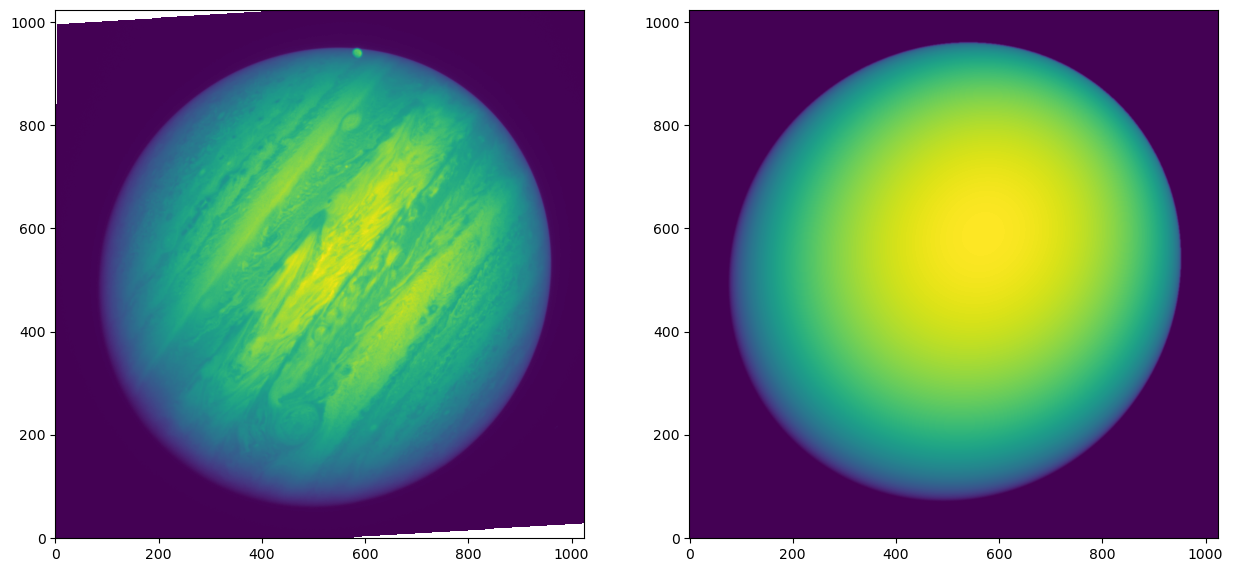

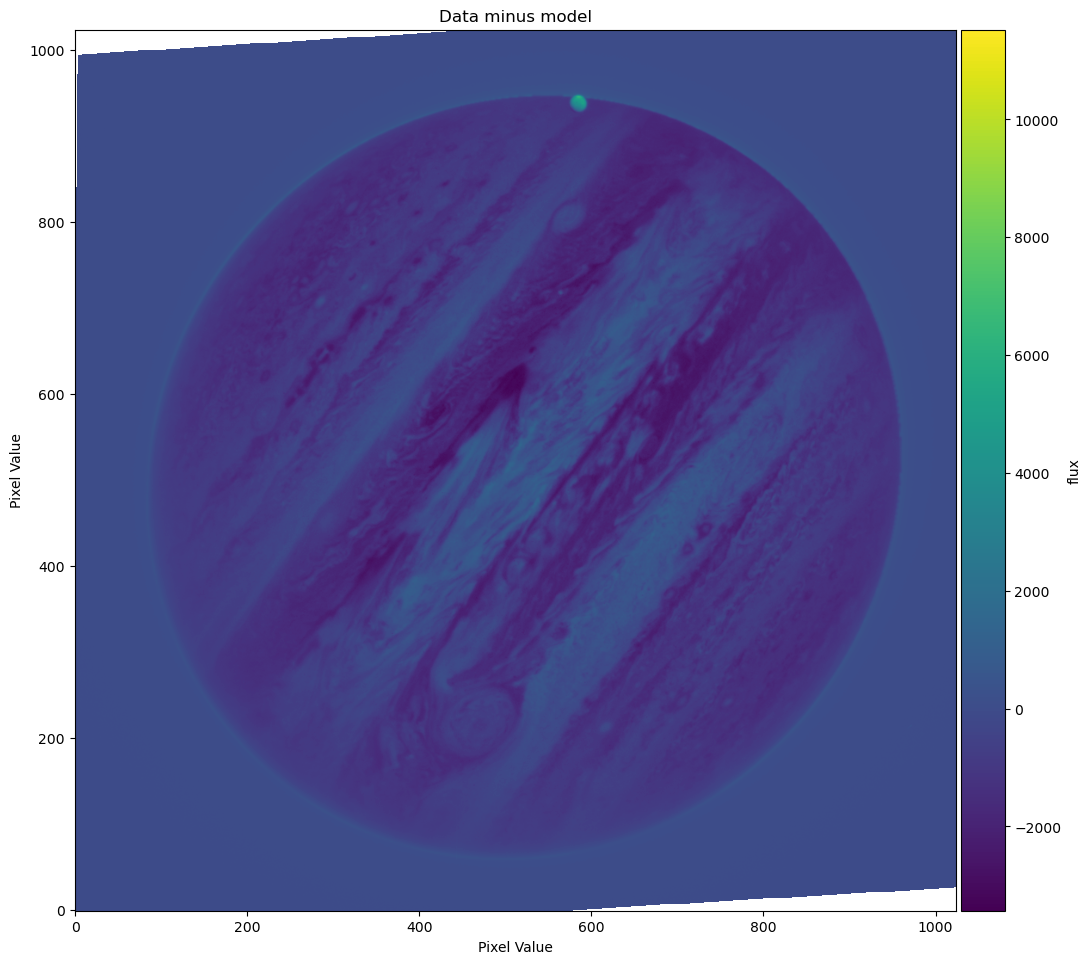

In [6]:
# plot the side-by-side comparison again
minnaert_k = 0.9
ldmodel = nav.ldmodel(flux, minnaert_k, beam=fwhm, law='minnaert')
fig, (ax0, ax1) = plt.subplots(1,2, figsize = (15,10))
ax0.imshow(nav.data, origin='lower')
ax1.imshow(ldmodel, origin = 'lower')
plt.show()

# re-try colocate with those parameters
dx, dy, dxerr, dyerr = nav.colocate(mode='disk', 
        tb = flux, 
        a = minnaert_k, 
        law = 'minnaert',
        beam = fwhm, 
        diagnostic_plot=True,
        )

The first plot shows that the model much more closely resembles the disk of Jupiter, and the second plot shows that the difference between data and model is indeed less; the code has found a much closer representation of the planet's center.  There now appears to be a bright halo around the entire planet, probably due to improper representation of the beam shape. This could be improved by using a standard star PSF as the beam instead, but we are happy for now. Let's go ahead and apply this solution

### applying the shift

Once we are happy with the values of dx and dy, we can move the model over by that amount. This will change the nav.lat_g, nav.lon_w, nav.mu, and nav.mu0 arrays to have the new center. If we want to do even better than this, we can either continue to improve the model, or manually fudge the numbers at this stage so the difference plot is visually bang-on.

In [7]:
nav.xy_shift_model(dx, dy)

### plotting and writing

Let's make some nice plots of this solution, and save the solution in the same format as the HST OPAL program uses

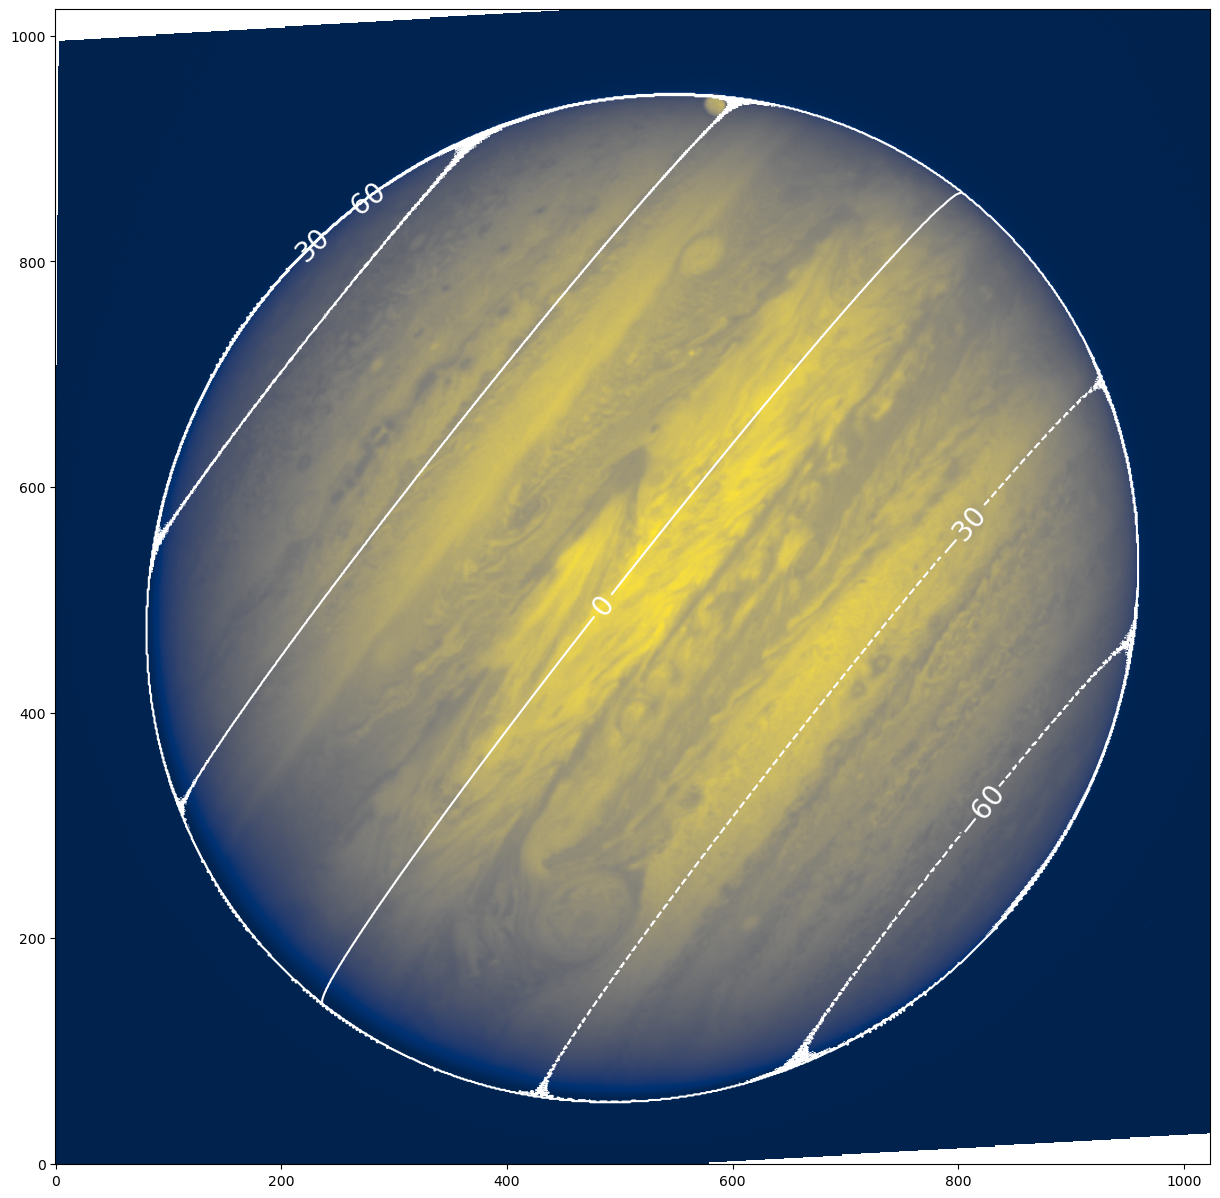

In [8]:
isplanet = np.copy(nav.lat_g)
isplanet[np.isnan(nav.lat_g)] = 0.0
isplanet[~np.isnan(nav.lat_g)] = 1.0

fig, (ax0) = plt.subplots(1,1, figsize=(15,15))
ax0.imshow(nav.data, origin='lower', cmap='cividis')
CS0 = ax0.contour(nav.lat_g, levels = np.arange(-90, 90, 30), colors='white')
ax0.clabel(CS0, CS0.levels, inline=True, fontsize=20)
ax0.contour(isplanet, levels=[0.5], colors='white')

plt.show()

Now let's write:

In [10]:
#nav.write('/Users/emolter/Desktop/delete-me.fits', header=hdul[0].header)